<a href="https://colab.research.google.com/github/Abhishek0917/Megahack/blob/main/RF_PCA_Hyper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [ ]:
%cd Tensorboard

/content/drive/My Drive/Tensorboard


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
import pandas as pd

PCOS_inf = pd.read_csv('./PCOS_infertility.csv')
PCOS_woinf = pd.read_excel('./PCOS_data_without_infertility.xlsx', sheet_name="Full_new")

data = pd.merge(PCOS_woinf,PCOS_inf, on='Patient File No.', suffixes={'','_y'},how='left')

data =data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', 
                 '  I   beta-HCG(mIU/mL)_y', 'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)

data.columns = [col.strip() for col in data.columns]

X=data.drop(["PCOS (Y/N)","Sl. No","Patient File No."],axis = 1)
y=data["PCOS (Y/N)"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2020, stratify=y)

In [ ]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

In [ ]:
import pickle
filename = 'RF_model_1.sav'
lm_rfc = pickle.load(open(filename, 'rb'))

acc_rfc_train = round(lm_rfc.score(X_train_scaled, y_train)*100,2) 
acc_rfc_test = round(lm_rfc.score(X_test_scaled,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_rfc_train))
print("Testing Accuracy: % {}".format(acc_rfc_test))

Training Accuracy: % 100.0
Testing Accuracy: % 87.16


In [ ]:
# PCA

pca = PCA(n_components=10)
pca.fit(X_train_scaled)

X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
filename = 'RF_model_PCA.sav'
lm_rfc_pca = pickle.load(open(filename, 'rb'))

acc_rfc_train = round(lm_rfc_pca.score(X_train_scaled_pca, y_train)*100,2) 
acc_rfc_test = round(lm_rfc_pca.score(X_test_scaled_pca, y_test)*100,2)
print("Training Accuracy: % {}".format(acc_rfc_train))
print("Testing Accuracy: % {}".format(acc_rfc_test))

Training Accuracy: % 100.0
Testing Accuracy: % 86.24


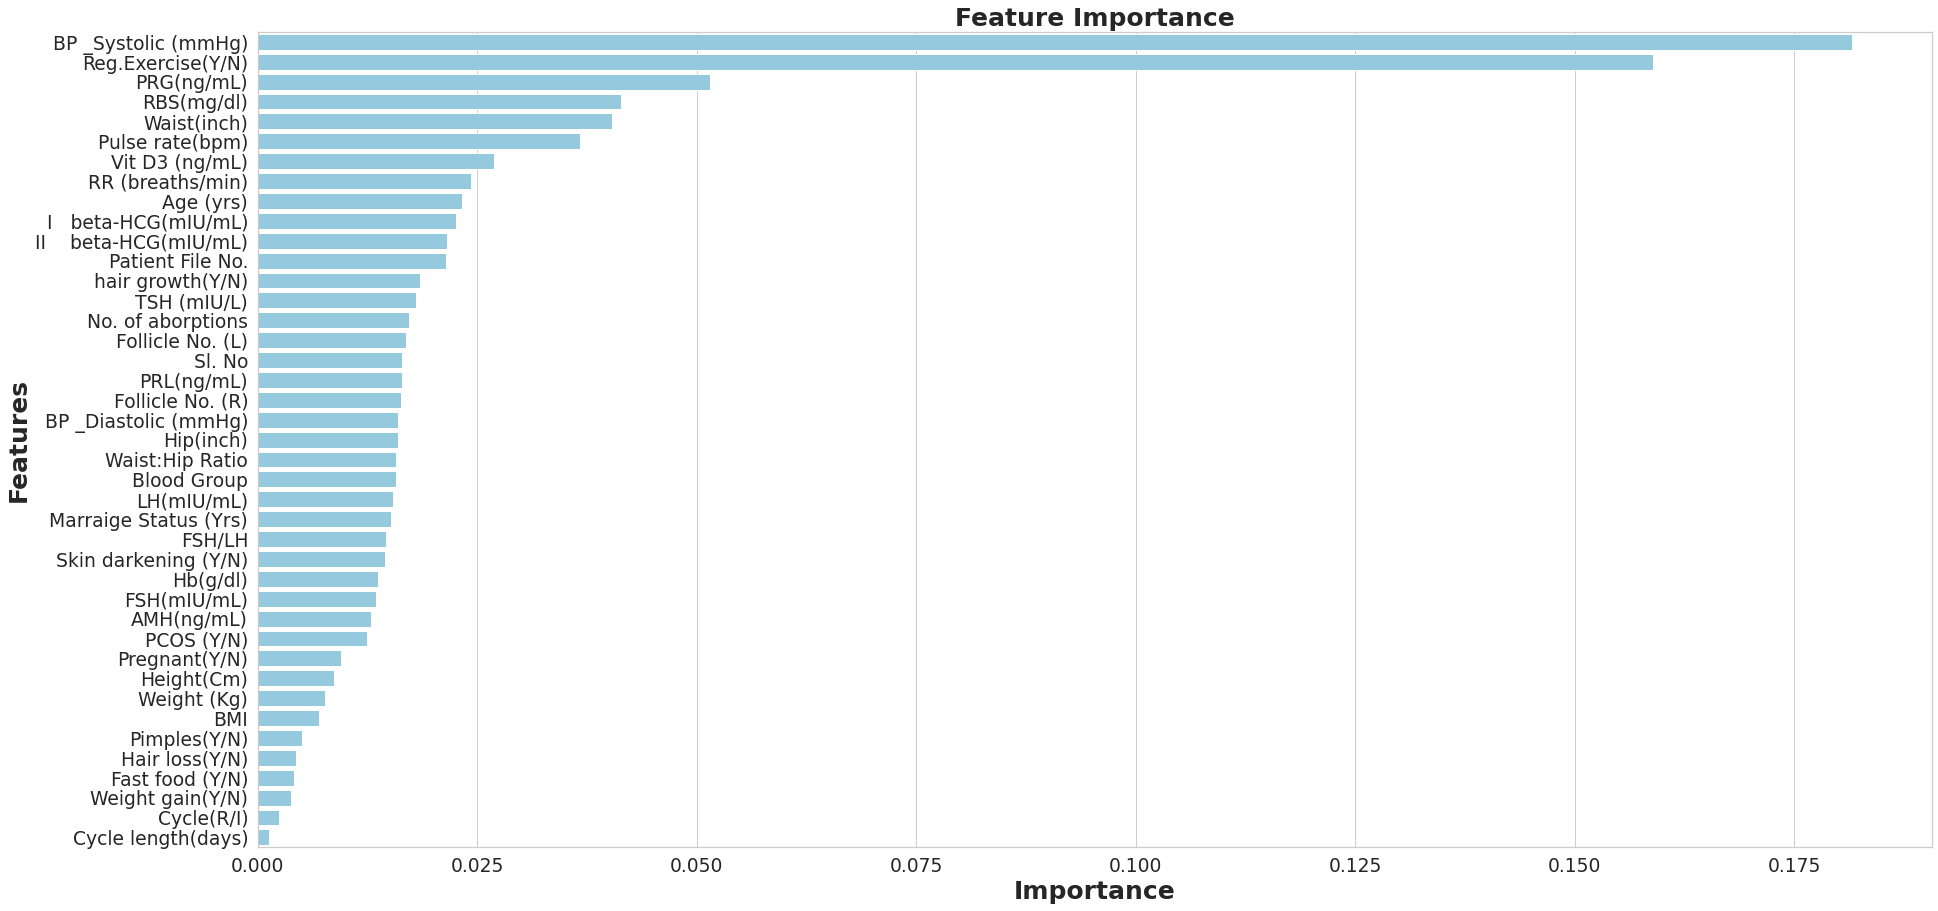

                  Features  Gini-Importance
0      BP _Systolic (mmHg)         0.181600
1        Reg.Exercise(Y/N)         0.158967
2               PRG(ng/mL)         0.051502
3               RBS(mg/dl)         0.041398
4              Waist(inch)         0.040379
5          Pulse rate(bpm)         0.036677
6           Vit D3 (ng/mL)         0.026936
7         RR (breaths/min)         0.024255
8                Age (yrs)         0.023328
9     I   beta-HCG(mIU/mL)         0.022571
10  II    beta-HCG(mIU/mL)         0.021567
11        Patient File No.         0.021454
12        hair growth(Y/N)         0.018488
13             TSH (mIU/L)         0.018059
14       No. of aborptions         0.017225
15        Follicle No. (L)         0.016867
16                  Sl. No         0.016493
17              PRL(ng/mL)         0.016487
18        Follicle No. (R)         0.016329
19    BP _Diastolic (mmHg)         0.015990
20               Hip(inch)         0.015975
21         Waist:Hip Ratio      

In [14]:
feats = {}
for feature, importance in zip(data.columns, lm_rfc.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')

plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')

plt.show()
print(importances)

In [16]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(lm_rfc_pca, param_dist, n_iter = 100, cv = 3, verbose = 1, n_jobs=-1, random_state = 40)
rs.fit(X_train_scaled_pca, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'bootstrap': False,
 'max_depth': 8,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 23,
 'n_estimators': 100}

In [19]:
import pickle

filename = 'RCV_model_PCA.sav'
pickle.dump(rs, open(filename, 'wb'))

In [20]:
lm_RCV = pickle.load(open(filename, 'rb'))

acc_qda_clf_train = round(lm_RCV.score(X_train_scaled_pca, y_train)*100,2) 
acc_qda_clf_test = round(lm_RCV.score(X_test_scaled_pca, y_test)*100,2)
print("Training Accuracy: % {}".format(acc_qda_clf_train))
print("Testing Accuracy: % {}".format(acc_qda_clf_test))

Training Accuracy: % 96.53
Testing Accuracy: % 88.07


In [21]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,100,23,2,log2,8,False,0.865741,1
1,500,7,2,sqrt,11,False,0.865741,1
2,200,23,2,sqrt,12,False,0.863426,3
3,400,7,2,sqrt,8,False,0.863426,3
4,900,2,12,sqrt,12,False,0.861111,5
5,400,28,2,log2,11,False,0.858796,6
6,100,23,12,sqrt,8,False,0.856481,7
7,800,23,2,log2,12,True,0.856481,7
8,200,34,2,sqrt,15,False,0.854167,9
9,500,28,2,log2,4,False,0.851852,10


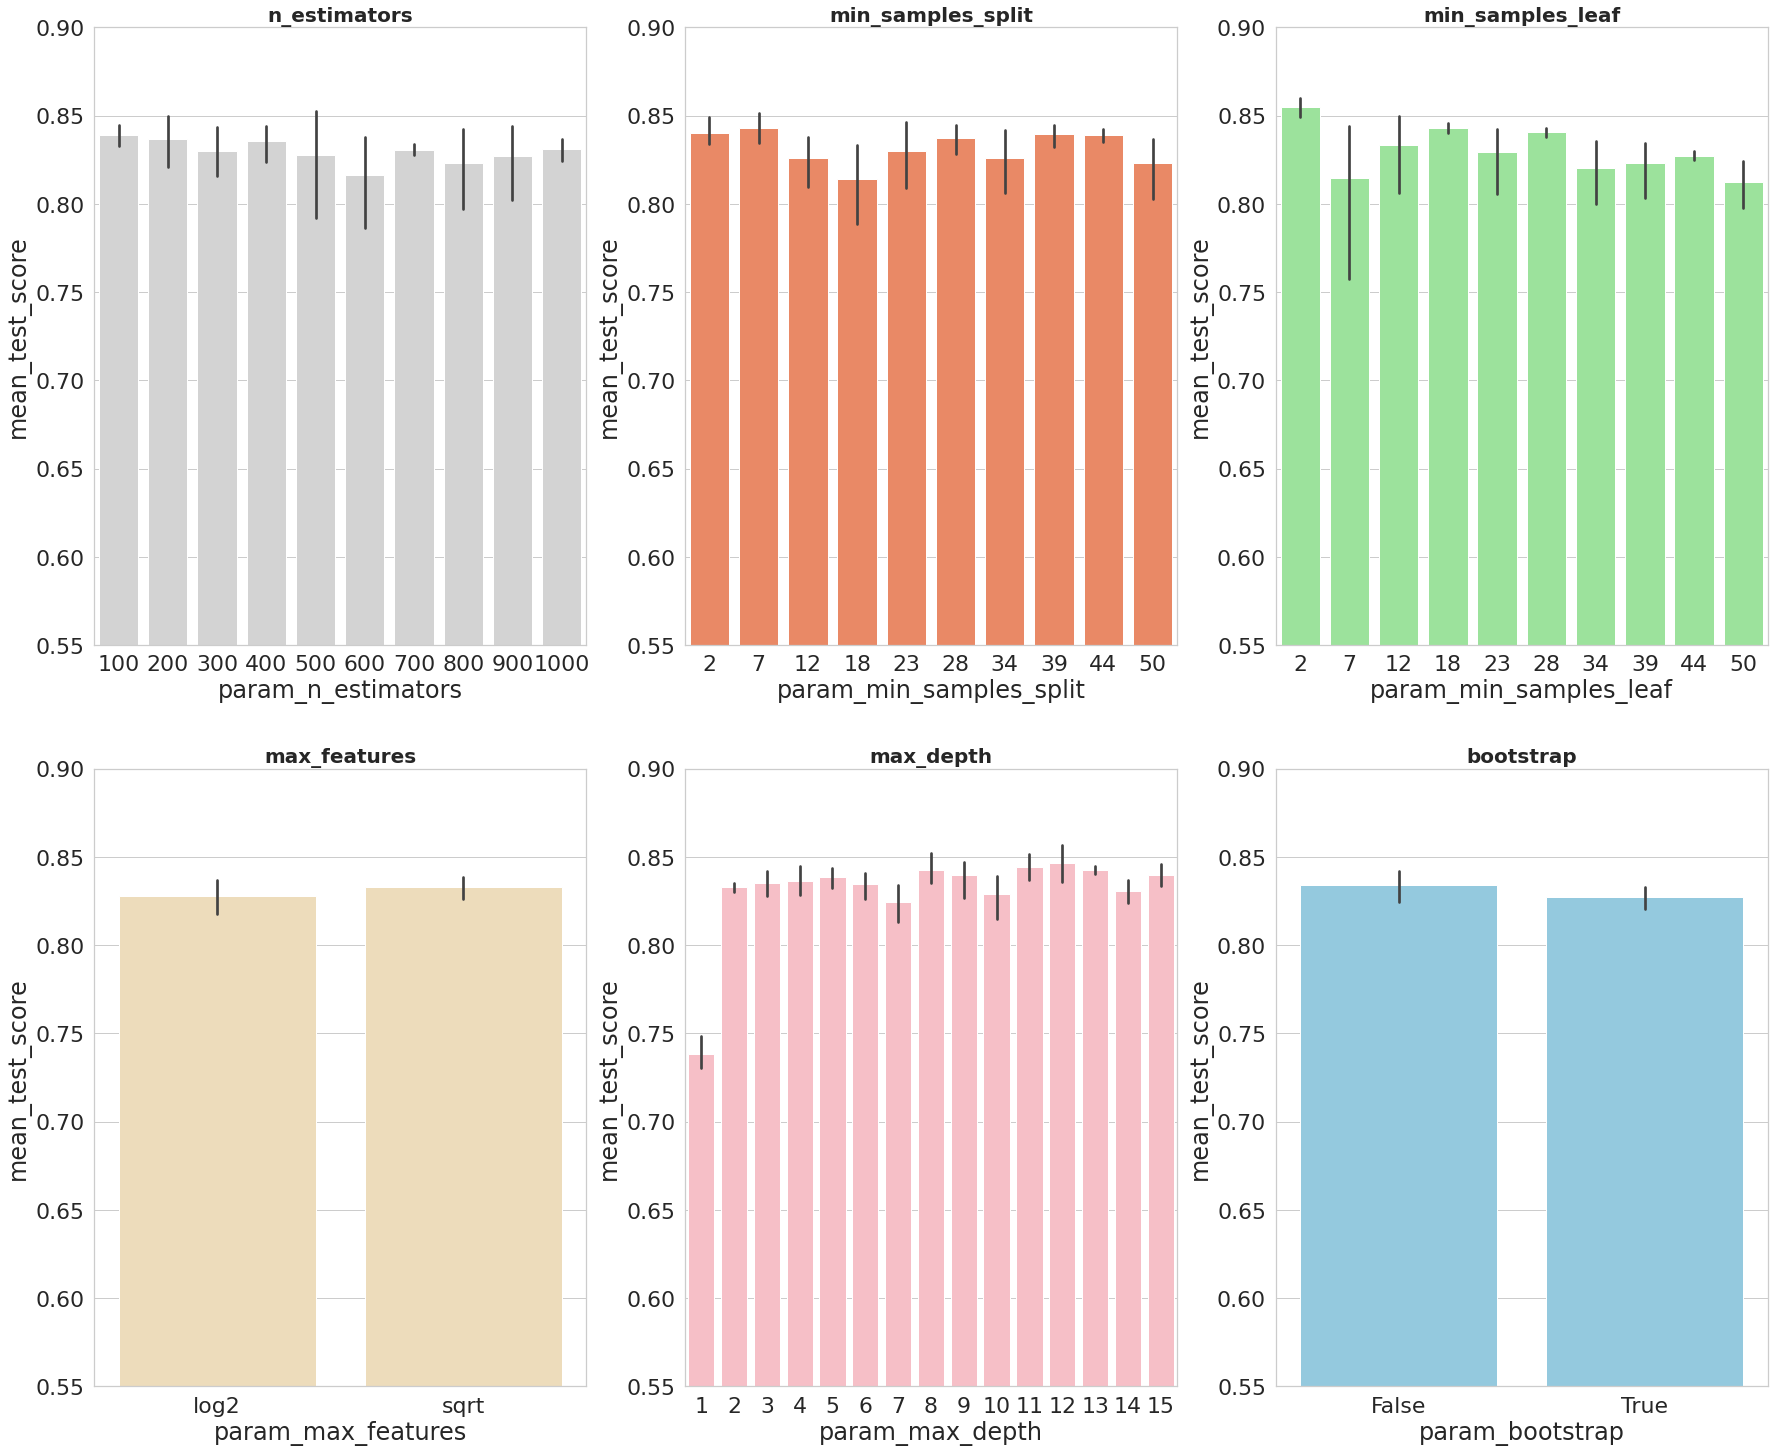

In [23]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)

fig.set_size_inches(30,25)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.55,.90])
axs[0,0].set_title(label = 'n_estimators', size=20, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.55,.90])
axs[0,1].set_title(label = 'min_samples_split', size=20, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.55,.90])
axs[0,2].set_title(label = 'min_samples_leaf', size=20, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.55,.90])
axs[1,0].set_title(label = 'max_features', size=20, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.55,.90])
axs[1,1].set_title(label = 'max_depth', size=20, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.55,.90])
axs[1,2].set_title(label = 'bootstrap', size=20, weight='bold')

plt.show()

In [24]:
#GRID CV

n_estimators = [300,500,700]
max_features = ['sqrt']
max_depth = [2,3,7,11,15]
min_samples_split = [2,3,4,22,23,24]
min_samples_leaf = [2,3,4,5,6,7]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(lm_rfc_pca, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_scaled_pca, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


{'bootstrap': False,
 'max_depth': 11,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 500}

In [25]:
filename = 'GSCV_model_PCA.sav'
pickle.dump(gs, open(filename, 'wb'))

In [26]:
lm_gscv = pickle.load(open(filename, 'rb'))

acc_gscv_train = round(lm_gscv.score(X_train_scaled_pca, y_train)*100,2) 
acc_gscv_test = round(lm_gscv.score(X_test_scaled_pca, y_test)*100,2)
print("Training Accuracy: % {}".format(acc_gscv_train))
print("Testing Accuracy: % {}".format(acc_gscv_test))

Training Accuracy: % 100.0
Testing Accuracy: % 88.99


In [41]:
# Metrics 
# ROC_AUC_OVO
from sklearn.metrics import roc_auc_score
ra_ovr_rf = roc_auc_score(y_test, lm_rfc.predict(X_test), multi_class='ovr')
ra_ovr_rf

0.5205479452054795

In [42]:
ra_ovr_rfc_pca = roc_auc_score(y_test, lm_rfc_pca.predict(X_test), multi_class='ovr')
ra_ovr_rfc_pca

0.5

In [43]:
ra_ovo_rf = roc_auc_score(y_test, lm_rfc.predict(X_test), multi_class='ovo')
ra_ovo_rf

0.5205479452054795